# Optimizers

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(2)

In [2]:
# Define a simple objective test function that we would like to maximize
def objective(x: float) -> float:
    return np.sin(5 * x) - x**2

# Define the reflection of the function that we would like to minimize
def cost(x: float) -> float:
    return -objective(x)

# Evaluate the true objective
xtest = np.linspace(-1, 1, 1001)
ytest = objective(xtest)

## Gradient Descent

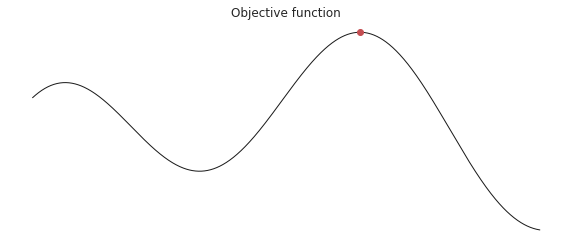

In [3]:
# Create the optimizer
gd = sia.GradientDescent(lower=np.array([-1]), upper=np.array([1]), n_starts=10)
xopt = gd.minimize(cost)

# plot function and minima
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.despine(f, left=True, bottom=True)
ax.plot(xtest, ytest, '-k', lw=1)
ax.plot(xopt, objective(xopt), '.r', ms=12)
ax.axis("off")
ax.set_title("Objective function");

## Bayesian Optimization

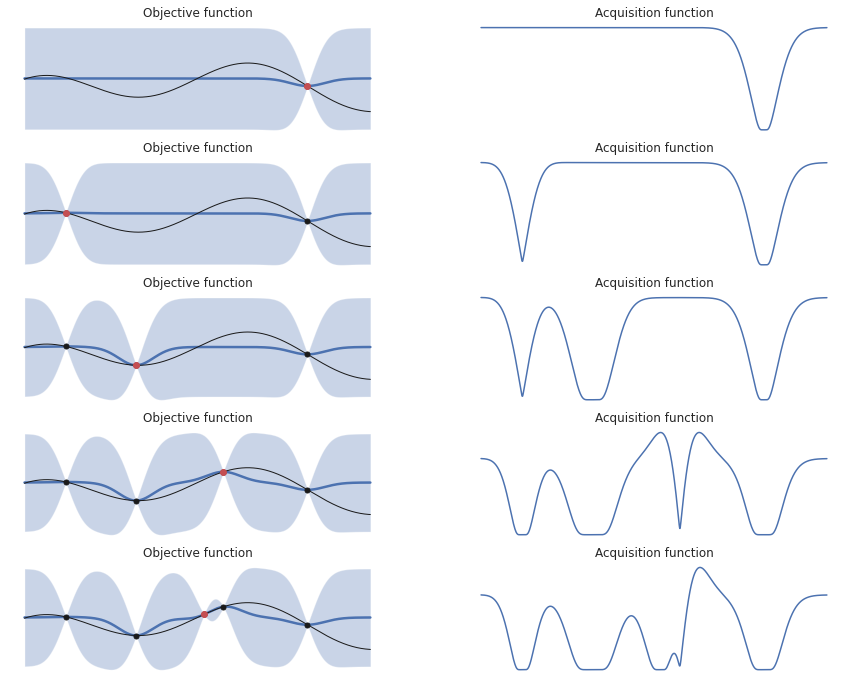

In [4]:
# Create the optimizer
EI = sia.AcquisitionType.EXPECTED_IMPROVEMENT
bo = sia.BayesianOptimizer(lower=np.array([-1]), upper=np.array([1]), acquisition=EI)

# Plot the raw data
n_samples = 5
f, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(15, 12))
sns.despine(f, left=True, bottom=True)
for i in range(n_samples):
    # Perform a step of the Bayesian optimization
    x = bo.selectNextSample()
    y = objective(x)
    bo.addDataPoint(x, y[0])
    bo.updateModel()

    # Evaluate the surrogate model
    surrogate = bo.surrogate()
    xopt = bo.getSolution()
    yopt = surrogate.objective(xopt).mean()[0]
    X = surrogate.inputData()
    Y = surrogate.outputData()
    atest = [surrogate.acquisition([xt], yopt, EI) for xt in xtest]
    gpr_mu = np.zeros(len(xtest))
    gpr_std = np.zeros(len(xtest))
    for k in range(len(xtest)):
        gaussian = surrogate.objective(np.array([xtest[k]]))
        gpr_mu[k] = gaussian.mean()[0]
        gpr_std[k] = np.sqrt(gaussian.covariance()[0, 0])
    
    # Plot the belief for each axis and overlay the training data
    ax[i, 0].fill_between(xtest, gpr_mu + 3 * gpr_std, gpr_mu - 3 * gpr_std,  alpha=0.3)
    ax[i, 0].plot(xtest, gpr_mu, 'b', lw=2.5)
    ax[i, 0].plot(xtest, ytest, '-k', lw=1)
    ax[i, 0].plot(X, Y, '.k', ms=10)
    ax[i, 0].plot(x, y, '.r', ms=12)
    ax[i, 0].axis("off")
    ax[i, 0].set_title("Objective function")

    ax[i, 1].plot(xtest, atest)
    ax[i, 1].set_title("Acquisition function")
    ax[i, 1].axis("off")